<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              367 non-null    object 
 1   Sex               367 non-null    object 
 2   Event             367 non-null    object 
 3   Equipment         367 non-null    object 
 4   Age               367 non-null    float64
 5   AgeClass          367 non-null    object 
 6   BirthYearClass    367 non-null    object 
 7   Division          367 non-null    object 
 8   BodyweightKg      367 non-null    float64
 9   WeightClassKg     367 non-null    object 
 10  Squat1Kg          367 non-null    float64
 11  Squat2Kg          364 non-null    float64
 12  Squat3Kg          362 non-null    float64
 13  Squat4Kg          0 non-null      float64
 14  Best3SquatKg      367 non-null    float64
 15  Bench1Kg          367 non-null    float64
 16  Bench2Kg          366 non-null    float64
 1

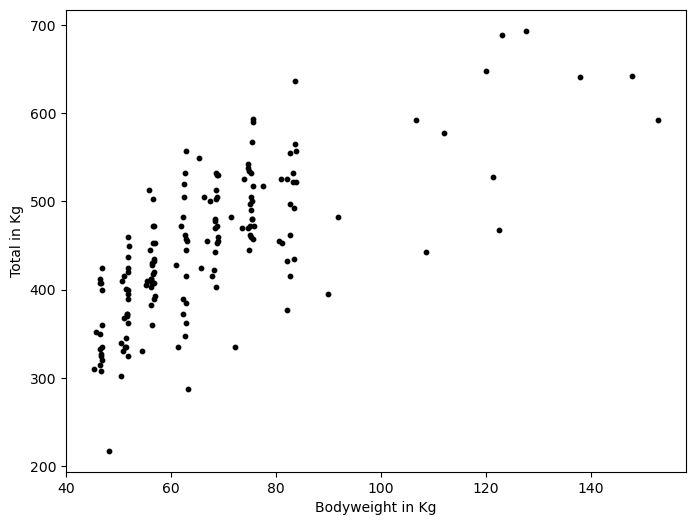

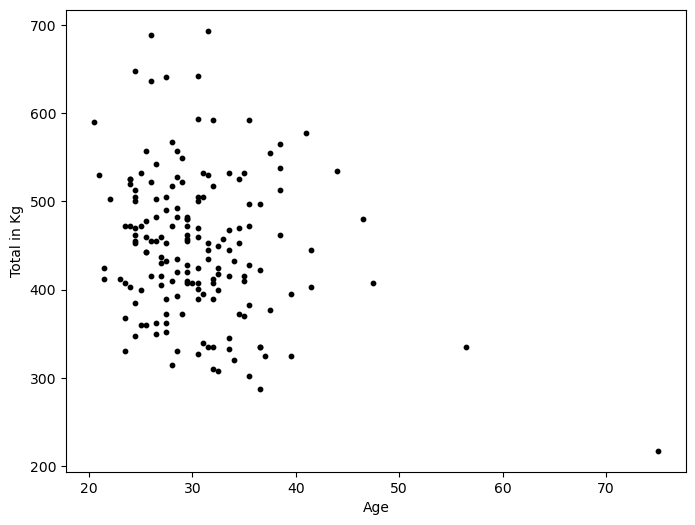

In [1]:
#import numpy, pandas and plotting tools
import numpy as np                   
import pandas as pd                  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import mean, correlate, cov

# Import regression tools & CV tools
%config Completer.use_jedi = False  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#change maximum number of rows and columns
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999

#import data
df = pd.read_csv('ipf_2023.csv')
df.info()

#clean data
df = df[df['Sex'] == 'F']
df = df[df['Best3SquatKg'] > 0] 
df = df[df['Best3BenchKg'] > 0]
df = df[df['Best3DeadliftKg'] > 0]
df = df[df['MeetName'] == 'World Classic Powerlifting Championships']

df = df[['Name','Sex', 'Age', 'AgeClass', 'BodyweightKg','WeightClassKg', 'TotalKg', 'Place','Dots','Wilks']]
print(df.head(5))

#sanity checking the variables under study
MaxValues = df.max()
print(MaxValues)
MinValues = df.min()
print(MinValues)

#scatter plot (bodyweight)
plt.figure(figsize=(8, 6)) 
plt.scatter(df['BodyweightKg'], df['TotalKg'], color='black', s=10) 
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')

#scatter plot (age)
plt.figure(figsize=(8, 6)) 
plt.scatter(df['Age'], df['TotalKg'], color='black', s=10) 
plt.xlabel('Age')
plt.ylabel('Total in Kg')

#correlation 
pd.options.display.float_format = '{:.2f}'.format
print(df.corr(method='pearson', min_periods=1, numeric_only=True))

#setting features and labels
features = []
labels = []
X = df[['BodyweightKg', 'Age']]
y = df['TotalKg']


feature = X.to_numpy()
features.append(feature)
label = y.to_numpy()
labels.append(label)

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print(X_test.shape)
print(X_train.shape)

#collect testing and validation errors
stats = []

#run linear regression with n-fold cv
cv = KFold(n_splits=len(X_train), shuffle=True, random_state = 1)

model = LinearRegression().fit(X_train,y_train)

scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
y_train_pred = model.predict(X_train)

scores = -scores
mean_error = np.mean(scores)

train_error = mean_squared_error(y_train, y_train_pred)

stats.append([1, train_error, mean_error])

print()
print("Linear regression intercept: ", model.intercept_)
print("Linear regression coefficient for bodyweight: ", model.coef_[0])
print("Linear regression coefficient for age: ", model.coef_[1])
print()

#run polynomial regression with n-fold cv
#Reference: CS-C3240 Machine Learning D (Autumn 2023), Assignment 1 Student task A1.9
degrees = [2,3,4,5]
cv_poly = KFold(n_splits=len(X_train), shuffle=True, random_state = 1)

for i in range(len(degrees)):
    poly = PolynomialFeatures(degree=degrees[i])
    X_poly = poly.fit_transform(X_train)
    poly_model = LinearRegression().fit(X_poly,y_train)
    
    y_poly_train_pred = poly_model.predict(X_poly)
    poly_train_error = mean_squared_error(y_poly_train_pred, y_train)
    
    scores = cross_val_score(poly_model, X_poly, y_train, cv=cv_poly, scoring='neg_mean_squared_error')
    scores = -scores
    mean_error = np.mean(scores)
    
    stats.append([degrees[i], poly_train_error, mean_error])
    
#print stats
table = pd.DataFrame(stats, columns = ['polynomial degree', 'training error', 'validation error'])
pd.options.display.float_format = '{:.1f}'.format
print(" Loss of linear and polynomial regressions:")
print(table.to_string(index=False))

#random forests
cv = KFold(n_splits=len(X_train), shuffle=True, random_state = 1)

model = RandomForestRegressor(max_depth=3, random_state=0)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
y_train_pred = model.predict(X_train)

scores = -scores
mean_error = np.mean(scores)

forest_train_error = mean_squared_error(y_train, y_train_pred)

print("Training error (MSE): ", forest_train_error)
print("K-fold cross validation error (MSE): ", mean_error)

#test model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly_model = LinearRegression().fit(X_poly,y_train)

X_poly_test = poly.fit_transform(X_test)
y_poly_pred = poly_model.predict(X_poly_test)

test_mae_error = mean_absolute_error(y_test, y_poly_pred)
test_mse_error = mean_squared_error(y_test, y_poly_pred)

#print stats
pd.options.display.float_format = '{:.4f}'.format

intercept = poly_model.intercept_
coefficients = poly_model.coef_[1:]
coefs = pd.DataFrame(coefficients)

mean_total = mean(df['TotalKg'])

print("Intercept: {:.2f}".format(intercept))
print("Coefficients:")
print()
print(coefs.to_string(index=False, header=False))
print()

print("Test error (MAE): {:.2f}".format(test_mae_error))
print("Test error (MSE): {:.2f}".format(test_mse_error))
print()

print('Mean of TotalKg: {:.2f}'.format(mean_total))